In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
prev_path = "\\".join(list(os.getcwd().split('\\')[0:-1]))
if module_path not in sys.path: sys.path.append(prev_path)

# you will need to pip install eikon=1.1.15 and maybe some other packages
# it's best if we share the venv 

from models.data.source import Eikon
from models.stat_models.linearregression import LinearRegressionModel, MultiOutputLinearRegressionModel
from models.unsupervised.pca import PcaHandler
from models.data.handler import DataHandler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = r'C:\Users\serge\IdeaProjects\portfolio_manager\data\fama-french-factors'
path_apikeys = r'C:\Users\serge\OneDrive\Documents\apikeys.csv'

In [3]:
rics_list = [
    'LVMH.PA', 'ASML.AS', 'NESN.S', 'LIN',
    'NOVOb.CO', 'AAPL.O', 'ROG.S', 'UNH',
    'SAPG.DE', 'MSFT.O'
]

params = {
    'rics': rics_list,
    'load_path': r'C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv',
    'field': ['TR.PriceClose', 'Price Close'],
    'date_field': ['TR.PriceClose.calcdate', 'Calc Date'],
}

In [4]:
N_PCA_COMPONENTS = 5
HORIZON_IN_DAYS = 14
RIC = "ASML.AS"

In [5]:
eikon_api = Eikon(path_apikeys)

In [6]:
 eikon_api.load_timeseries(**params)

Loaded: LVMH.PA
Loaded: ASML.AS
Loaded: NESN.S
Loaded: LIN
Loaded: NOVOb.CO
Loaded: AAPL.O
Loaded: ROG.S
Loaded: UNH
Loaded: SAPG.DE
[Errno 2] No such file or directory: 'C:\\Users\\serge\\IdeaProjects\\portfolio_manager\\portfolio_management\\models\\data\\csv\\MSFT.O.csv'


In [7]:
data = eikon_api.data.copy()
data.head(20)

,Calc Date,LVMH.PA,ASML.AS,NESN.S,LIN,NOVOb.CO,AAPL.O,ROG.S,UNH,SAPG.DE
0,2000-01-04,72.458651,38.039234,28.00,24.46875,17.550,0.915178,175.423964,6.632812,39.076938
1,2000-01-05,70.007313,34.411467,27.80,24.90625,17.136,0.928570,171.065003,6.617188,34.361184
2,2000-01-06,69.214234,32.004583,28.96,26.75000,17.550,0.848213,172.808587,6.859375,35.475892
3,2000-01-07,69.214234,34.394026,29.53,26.78125,17.910,0.888392,182.592033,7.664062,43.013639
4,2000-01-10,72.134209,36.870674,29.23,26.81250,19.260,0.872767,184.819946,7.531250,44.770651
5,2000-01-11,73.540123,37.324145,29.30,27.25000,19.170,0.828124,183.076362,7.546875,46.204439
6,2000-01-12,76.784540,36.800910,29.93,26.78125,18.990,0.778459,183.076362,7.476562,47.157535
7,2000-01-13,81.470921,37.202057,30.05,26.40625,18.900,0.863838,183.076362,7.710938,47.654802
8,2000-01-14,84.715338,41.597237,30.21,26.71875,18.360,0.896762,184.045020,7.703125,48.732215
9,2000-01-17,83.814111,43.602974,29.95,26.71875,18.360,0.896762,184.626215,7.703125,47.986314


In [ ]:
data_handler = DataHandler(data=data, date_col=params['date_field'][1])
df = DataHandler.get_returns(period=HORIZON_IN_DAYS, out=True)

In [8]:
# T = len(data)
# tau = 12
# df = {}
# for t in np.arange(0, T-tau, tau):
#     df[data.iloc[t+tau,0]]= np.log(data.iloc[t+tau,1:].astype(float).values / data.iloc[t,1:].astype(float).values)
# df = pd.DataFrame.from_dict(df, orient='index')
# df.columns = data.columns[1:]

# this is unit test for tau=12
# assert np.isclose(df.iloc[0,0],np.log(79.848712 / 72.458651))

In [9]:
df.head()

,LVMH.PA,ASML.AS,NESN.S,LIN,NOVOb.CO,AAPL.O,ROG.S,UNH,SAPG.DE
2000-01-24,0.065005,0.233634,0.010657,-0.003839,0.020305,0.035932,0.013165,0.039266,0.208832
2000-02-11,-0.047009,0.010471,-0.078630,-0.259036,0.053803,0.023257,0.009492,0.014615,0.120648
2000-03-02,-0.076912,0.067363,0.089175,-0.140676,0.000000,0.114969,-0.001350,-0.064539,0.058945
2000-03-22,0.076179,-0.113302,0.031661,0.140676,0.077842,0.167093,0.039740,0.008299,0.028624
2000-04-11,0.047275,-0.069692,0.031018,0.169224,-0.054312,-0.188321,-0.067139,0.211984,-0.336598


In [10]:
pca_model = PcaHandler(np.array(df))

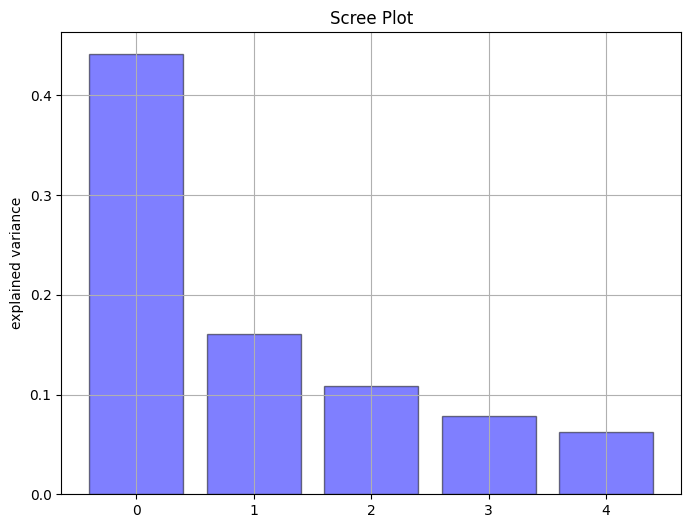

In [11]:
pca_model.plot(N_PCA_COMPONENTS)

In [12]:
pca_factors = pca_model.components(N_PCA_COMPONENTS)
x = pca_factors

In [13]:
pca_model.singular_values

array([2.70736428, 1.63390884, 1.34467586, 1.13673467, 1.01573073,
       0.96046253, 0.81901246, 0.76380706, 0.56954829])

In [14]:
pca_model.benchmark_test()

[-7.58941521e-19  2.50450702e-17  5.96311195e-18  8.13151629e-18
  9.43255890e-18  1.20346441e-17  4.44522891e-18  6.64073831e-18
  1.73201297e-17]


In [15]:
mod = LinearRegressionModel(x=x, y=np.array(df[RIC]))

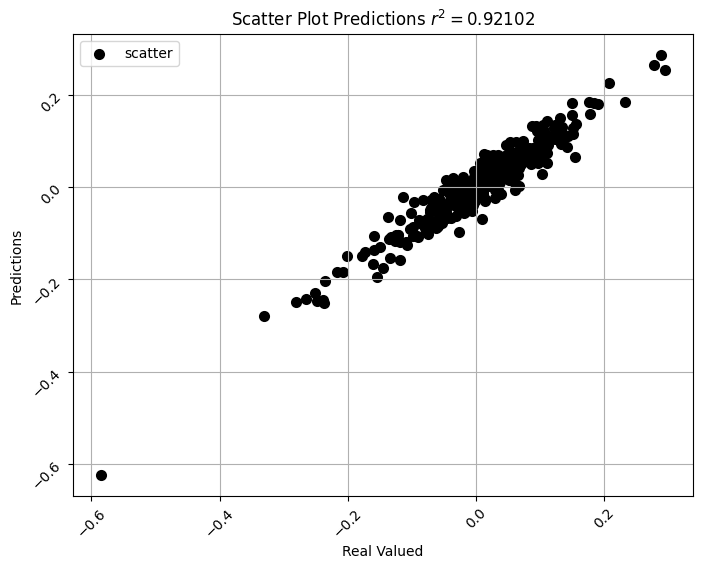

In [16]:
mod.plot()

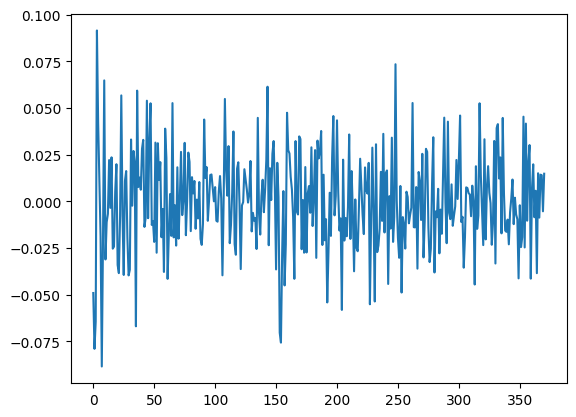

In [17]:
plt.plot(mod.residuals)

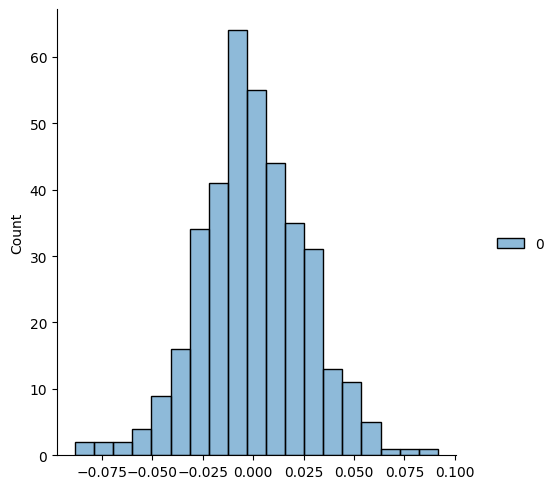

In [18]:
sns.displot(mod.residuals)

In [19]:
## Rolling estimation

In [20]:
T

5199

In [21]:
T = len(df)
period = int(T/2)
params = {}
for i in range(T):
    try:
        df_sliced = df.iloc[i:i+period, :]
        pca_model = PcaHandler(df_sliced)
        factors = pca_model.components(N_PCA_COMPONENTS)
        mod = LinearRegressionModel(x=factors, y=np.array(df_sliced["ASML.AS"]))
        params[i] = mod.beta.flatten()
    except:
        params[i] = np.repeat(np.nan, N_PCA_COMPONENTS)

In [22]:
rolling_betas = pd.DataFrame.from_dict(params, orient='index')

In [23]:
rolling_betas

,0,1,2,3,4,5
0,-0.002308,-0.593992,0.296939,-0.032153,3.905426e-01,-8.631893e-02
1,-0.004301,0.589842,-0.301003,0.031705,-3.930273e-01,1.022129e-01
2,-0.004242,0.587519,-0.303304,0.021471,-4.256053e-01,2.144180e-01
3,-0.004617,-0.587061,0.304206,-0.028518,4.346747e-01,-2.236811e-01
4,-0.003480,-0.591248,0.293394,-0.034371,4.084504e-01,-2.255039e-01
...,...,...,...,...,...,...
366,NaN,NaN,NaN,NaN,NaN,NaN
367,0.037109,0.625000,2.000000,-0.250000,-1.688850e+15,4.503600e+15
368,0.125000,-0.375000,-6.000000,0.000000,0.000000e+00,0.000000e+00
369,NaN,NaN,NaN,NaN,NaN,NaN


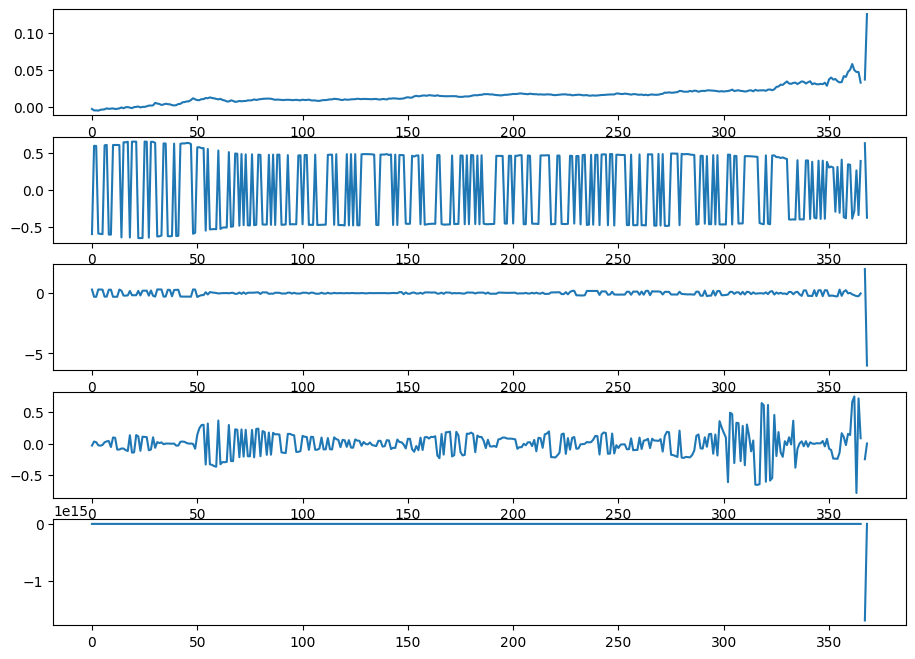

In [25]:
fig, axs = plt.subplots(N_PCA_COMPONENTS,1,figsize=(11,8))
for i in range(N_PCA_COMPONENTS):
    rolling_betas.iloc[:,i].plot(ax=axs[i])
plt.show()

In [ ]:
rolling_betas.dropna()